In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from enum import Enum
from units import unit
from tqdm import * #progress bar
btc = unit('btc')
usd = unit('$')
usdpbtc = usd/btc
machine_precision = 1.0e-14 #todo: create function for abs() instead of copypaste, or do in class with member fun or overload...

In [2]:
global_price = [usdpbtc(0.0649)]

epsilon = 1.4e-4 #fiat price per Wh
def R(t): #hash rate which can be bought for 1$
    return 42.
def P(t): #power consumption
    return 42. 
def B(t): # number of btc to be mined per day
    if t < 853: #todo properly
        return 72.
    else:
        return 36.
def p(t): #current price
    try:
        price = global_price[t]
    except:
        price = p(t-1)
    return price
        

In [3]:
def rtot(t): #hashing capability of whole population of miners at time t
    return sum(miner_.r(t) for miner_ in miners)

In [4]:
class Order:
    class Kind(Enum):
        BUY = 1
        SELL = 2
    def __init__(self, kind, amount, limit_price, time,  t_expiration, agent):
        self.agent = agent
        self.kind = kind
        self.amount = amount #sell: in btc ,  buy: in $
        self.residual = amount #sell: in btc ,  buy: in $
        self.t_expiration = t_expiration
        self.time = time
        self.limit_price=limit_price # $ per btc
    def __repr__(self):
        return "BTC {} order of {} with residual {} and limit {}".format(self.kind, self.amount, self.residual, self.limit_price)


In [5]:
class Exchange: #TODO maybe move orderbook to its own class
    def __init__(self):
        self.orderbook = dict(zip(list(Order.Kind), [list() for _ in range(len(Order.Kind))]))
        # access as orderbook[Order.Kind.BUY],  orderbook[Order.Kind.SELL]
    
    def match(self, buy, sell): #todo: move to order class
        return (sell.limit_price <= buy.limit_price) or (sell.limit_price==usdpbtc(0.)) or (buy.limit_price ==usdpbtc(0.)) 
                            # sj <= bi
    def place(self, order):
        #print("order placed: {}".format(order))
        self.orderbook[order.kind].append(order)
        self.clear()
        
    def clear(self): #process all available orders
        #first sort orders
        self.orderbook[Order.Kind.SELL].sort(key=lambda o: o.limit_price) #sort should be stable, so asc time conserved
        self.orderbook[Order.Kind.BUY].sort(key=lambda o: o.limit_price, reverse=True)

        #iterate through and match orders:      
        matching = True
        while matching and len(self.orderbook[Order.Kind.SELL]) and len(self.orderbook[Order.Kind.BUY]): #while there are orders
            buy = self.orderbook[Order.Kind.BUY][0]
            sell = self.orderbook[Order.Kind.SELL][0]
            
            if self.match(buy, sell): #see if they match
                self.process(buy, sell)
            else:
                matching = False #no more matching orders
    
    def process(self, buy, sell):
        #print(buy)
        #print(sell)
        #determine price of transaction pT in $ per btc
        if buy.limit_price > usdpbtc(0.) and sell.limit_price == usdpbtc(0.):
            pT = min(buy.limit_price, p(t))
        elif sell.limit_price > usdpbtc(0.) and buy.limit_price == usdpbtc(0.):
            pT = max(sell.limit_price, p(t))
        elif sell.limit_price == usdpbtc(0.) and buy.limit_price == usdpbtc(0.):
            pT = p(t)
        else: # buy.limit_price > 0 and sell.limit_price > 0
            pT = 0.5 * (buy.limit_price + sell.limit_price)
            
        #determine amount of transaction
        amount = min(sell.residual, buy.residual/pT) # amount that is actually traded
        assert amount > btc(0.) 
        #exchange currency
    
        assert (sell.agent.bitcoin_orders - amount) >= btc(-machine_precision)
        assert (buy.agent.bitcoin_available + amount) >= btc(-machine_precision)
        assert (sell.agent.cash_available + amount * pT) >= usd(-machine_precision)
        assert (buy.agent.cash_orders - amount * pT) >= usd(-machine_precision)
        
        sell.agent.bitcoin_orders -= amount
        if abs (sell.agent.bitcoin_orders) < btc(machine_precision):
            sell.agent.bitcoin_orders = btc(0.)
        buy.agent.bitcoin_available += amount
        sell.agent.cash_available += amount * pT
        buy.agent.cash_orders -= amount * pT   
        if abs (buy.agent.cash_orders) < usd(machine_precision):
            buy.agent.cash_orders = usd(0.)
            
        #update price:
        try:
            global_price[t] = pT
        except:
            global_price.append(pT)

        if (sell.residual < buy.residual / pT): #avoid testing for ==0. with float
            toremove = sell
        else:
            toremove = buy
        buy.residual -= amount * pT
        sell.residual -= amount
        self.remove_order(toremove)
            
    def remove_order(self, order):
        if order.kind == Order.Kind.SELL: #sell bitcoin
            order.agent.bitcoin_available += order.residual
            order.agent.bitcoin_orders -= order.residual   
            if abs(order.agent.bitcoin_orders) < btc(machine_precision):
                order.agent.bitcoin_orders = btc(0.)
        else: #buy bitcoin
            order.agent.cash_available += order.residual
            order.agent.cash_orders -= order.residual
            if abs(order.agent.cash_orders) < usd(machine_precision):
                order.agent.cash_orders = usd(0.)
        self.orderbook[order.kind].remove(order)
        #print("order removed: {}".format(order))
            
    def remove_old_orders(self):
        for kind in list(Order.Kind):
            book = self.orderbook[kind]
            for order in book: #todo do this in one nice line :D
                if  t - order.time > order.t_expiration:
                    self.remove_order(order)
                


In [6]:
coinbase = Exchange() 

In [7]:
class CryptoCurrencyAgent(Agent):
    """An agent"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.cash_available = usd(5.) #fiat cash
        self.bitcoin_available = btc(10.) #cryptocurrency
        self.cash_orders = usd(0.) #fiat cash
        self.bitcoin_orders = btc(0.) #cryptocurrency
        self.te = 0. #entry time
        self.bitcoin_in_sell_orders = btc(0.)
        self.cash_in_buy_orders = usd(0.)

        self.exchange = coinbase
    
    @property
    def cash_total(self):
        return self.cash_available + self.cash_orders
    @property
    def bitcoin_total(self):
        return self.bitcoin_available + self.bitcoin_orders
    #@property 
    #def cb(self): #$ not in buy orders, todo do this in a more efficient way
    #    return sum(order.amount for order in self.exchange.orderbook[Order.Kind.SELL] if order.agent==self ) 
    #@property    
    #def bs(self): #btc not in buy orders
    #    return sum(order.amount for order in self.exchange.orderbook[Order.Kind.BUY] if order.agent==self) #TODO dont copypaste

    def placeorder(self, order):
        if order.kind == Order.Kind.SELL: #sell bitcoin
            self.bitcoin_orders += order.amount
            self.bitcoin_available -= order.amount
            if abs (self.bitcoin_available) < btc(machine_precision):
                self.bitcoin_available = btc(0.)
            #print(self.bitcoin_orders)
            #assert self.bitcoin_available >= btc(0.)
            
        else: #buy bitcoin
            self.cash_orders += order.amount
            self.cash_available -= order.amount
            if abs (self.cash_available) < usd(machine_precision):
                self.cash_available = usd(0.)
            #print(self.cash_orders)
            #assert self.cash_available >= usd(0.)

        self.exchange.place(order)

In [8]:
class Miner(CryptoCurrencyAgent):
    """A Miner"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.gamma1_ = [0.5] #percentage of cash allocated to buy
        if t==0:
            self.tID = random.choice(range(61)) #take decision to buy in the first 60 days uniform distr, todo use np
        else:
            self.update_tID() #time when to buy new mining hardware
    
    def update_tID(self):
        mu, sigma = 0, 6.
        self.tID = t + round(60 + np.random.normal(mu, sigma))
    def gamma(self,t):
        return 0.5 * self.gamma1(t)
    def gamma1(self,t):
        return self.gamma1_[t-te]
    
    def ru(self, t): #hardware capability of units bought
        if t==te:
            return gamma1(t) * c(t) * R(t)
        else:
            return ( gamma1(t) * c(t) + gamma(t) * b(t)*p(t) )*R(t)
    def r(self, t): #hashing capability
        return sum( self.ru(s) for s in range(self.te, t) )
    def e(self, t): #total elextricity cost
        return sum( epsilon * P(s) * self.r(s) * 24 for s in range(self.te, t) )

    def b_mined(self, t): #amount mined at day t
        return self.r(t)/rtot(t) * B(t)
    
    def buy_hardware(self):
        #todo
        #buy hardware
        #divest hardware older than one year
        None
    def step(self):
        if t==self.tID:
            self.buy_hardware()
            #todo
            #set next time when to buy
            self.update_tID()
        self.bitcoin_available += self.b_mined(t)
        None

In [9]:

class Chartist(CryptoCurrencyAgent):
    """A Miner"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        

In [10]:
class Trader(CryptoCurrencyAgent):
    """A Miner"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.tradeprobability = 0.2 #todo
    def step(self):
        if (random.random() < self.tradeprobability):
            beta = min(1., np.random.lognormal(mean=0.25, sigma=0.2))
            mu, sigma = 1, 0.05 # TODO correct values
            N = np.random.normal(mu, sigma)
            kind = random.choice(list(Order.Kind))
            order_is_valid = True
            if kind == Order.Kind.BUY:
                amount = self.cash_available * beta #ba
                order_is_valid =  (amount > usd(0.))
                limit = p(t) * N
            else: #SELL
                amount = self.bitcoin_available * beta #sa
                order_is_valid =  (amount > btc(0.))
                limit = p(t) / N
            
            expiration_time = round(np.random.lognormal(mean=3, sigma=1))
            #todo
            if not expiration_time > 0:
                order_is_valid = False
            assert limit >= usdpbtc(0.) #wqit
            #kind, amount, limit_price, time,  t_expiration, agent
            if order_is_valid:
                self.placeorder(Order(kind , amount, limit, t, expiration_time, self) )



In [11]:
class CryptoCurrencyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Create agents
        #for i in range(self.num_agents):
        #    a = Miner(i, self)
        #    self.schedule.add(a)
        for i in range(self.num_agents):
            a = Trader(i, self)
            self.schedule.add(a)
    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()

In [12]:
model = CryptoCurrencyModel(500)
t=0

In [13]:
nsteps = 1000
for i in tqdm(range(nsteps)):
    #print(t)
    t += 1 #todo use mesa time
    coinbase.remove_old_orders() #todo move this into step
    model.step()

100%|██████████| 1000/1000 [03:16<00:00,  5.10it/s]


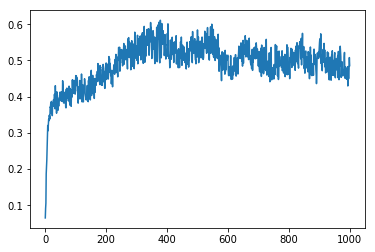

In [14]:
plt.plot(global_price)
plt.show()

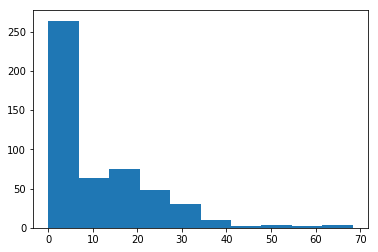

min: 0.0
max: 68.36799605231263


In [15]:
agent_btc = [float(a.bitcoin_total) for a in model.schedule.agents]
plt.hist(agent_btc)
plt.show()
print("min: {}".format(min(agent_btc)))
print("max: {}".format(max(agent_btc)))

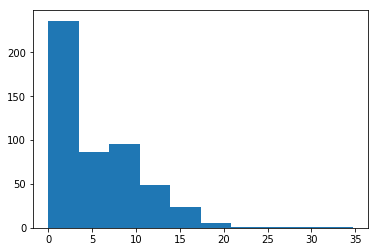

min: -8.881784197001252e-16
max: 34.7149040351392


In [16]:
agent_cash = [float(a.cash_total) for a in model.schedule.agents]
plt.hist(agent_cash)
plt.show()
print("min: {}".format(min(agent_cash)))
print("max: {}".format(max(agent_cash)))